# Creating a Dataset

In [ ]:
import torch 
import pandas as pd 
import numpy as np 

from torch.utils.data import Dataset 

class WaterDataset(Dataset): 
    def __init__(self, csv_path): 
        df=pd.read_csv(csv_path)
        self.data = df.to_numpy() 

    def __len__(self):
        return self.data.shape[0] 

    def __getitem__(self, idx): 
        features = self.data[idx, :-1]
        label = self.data[idx, -1]
        return features, label 


# Creating a DataLoader

In [ ]:
dataset_train = WaterDataset("../data/water_potability.csv")

In [ ]:
from torch.utils.data import DataLoader 

dataloader_train = DataLoader(
    dataset_train, 
    batch_size=2, 
    shuffle=True
)

features, labels = next(iter(dataloader_train))
print(f"features: {features}, \nLabels: {labels}")

# Defining a Net

In [ ]:
import torch.nn as nn

class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(9,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x 

net = Net()

# Training Loop 

In [ ]:
import torch.nn as nn 
import torch.optim as optim 

criterion = nn.BCELoss() 
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(1000): 
    for features, labels in dataloader_train: 
        features = features.float() 
        optimizer.zero_grad() 
        outputs = net(features)
        loss = criterion(
            outputs.double(), labels.view(-1, 1)
        )
        loss.backward()
        optimizer.step()

# Optimizing Weights 

The most used optimazer is **Adam** (Adaptative Momentum) that mixes RMSProp and gradient momentum.

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.01)


# Model Evaluation

In [ ]:
# Since I dont know yet how to do the train test split in pytorch.... 
dataloader_test = dataloader_train

In [ ]:
from torchmetrics import Accuracy 

acc = Accuracy(task='binary') 

net.eval()

with torch.no_grad(): 
    for features, labels in dataloader_test: 
        outputs = net(features.float()) 
        preds = (outputs >=0.5).float()
        acc(preds, labels.view(-1, 1))

accuracy = acc.compute() 

print(f"Accuracy: {accuracy}")

        

# Unstable Gradients
Neural networks often suffer from gradient instability during training. Sometimes, the gradients become smaller during the backward pass, known as **vanishing gradients**. As a result, earlier layers receive minimal parameter updates, hindering the model's ability to learn. In contrast, gradients may grow increasingly large, leading to massive parameter updates and divergent training, known as **exploding gradients**.

To address these issues, a three-step approach is recommended: proper weights initialization, appropriate activation functions, and batch normalization.

## Weights Initialization
When a torch layer is created, its parameters in the weight attribute are initialized to random values. Research suggests initialization should maintain the variance of inputs and outputs and ensure the variance of gradients is consistent before and after passing through the layer. For ReLU and similar activations, He initialization (also known as Kaiming initialization) is typically used.

### He / Kaiming Initialization
To apply this initialization, call `kaiming_uniform_` from `torch.nn.init` on the layer's weight attribute, ensuring the desired variance properties. In the final layer using sigmoid activation, specify the nonlinearity as sigmoid during initialization.

## Activation Functions
The ReLU (Rectified Linear Unit) is the most commonly used activation function. While efficient, it suffers from the dying neuron problem: neurons output zero for any negative input, effectively dying. The ELU (Exponential Linear Unit) activation improves upon ReLU by allowing non-zero gradients for negative values, reducing the likelihood of vanishing gradients and dying neurons.

## Batch Normalization
Even with proper weights and activations, unstable gradients can still arise during training. Batch normalization addresses this by normalizing a layer's outputs, ensuring the output distribution is roughly normal. It then applies learned scale and shift parameters, allowing the model to learn optimal input distributions for each layer. This stabilizes gradient behavior and accelerates loss convergence.

To implement batch normalization in PyTorch, define the `BatchNorm1d` layer in the model's `__init__` method, matching the preceding layer's output size. Then, pass the linear layer's output to the batch normalization layer before applying the activation function.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
        # Apply He initialization
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(
            self.fc3.weight, 
            nonlinearity='sigmoid'
        )

    def forward(self, x):
        # Update ReLU activation to ELU
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

# Handling Images in Pytorch

In [ ]:
from torchvision.datasets import ImageFolder 
from torchvision import transforms 

train_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((128, 128))
])

dataset_train = ImageFolder(
    "../data/clouds/clouds_train",
    transform = train_transforms
)

In [ ]:
dataloader_train = DataLoader(
    dataset_train, 
    shuffle = True,
    batch_size=1
)

image, label = next(iter(dataloader_train))
print(image.shape)


In [ ]:
image= image.squeeze().permute(1, 2, 0)
print(image.shape)

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.show()

# Data Augmentation

> When doing data augmentation always keep the data and the task in mind, since sometimes the augmented data could correspond to other classes!!

In [ ]:

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(), 
    transforms.Resize((128, 128))
])

dataset_train = ImageFolder(
    "../data/clouds/clouds_train",
    transform = train_transforms
)

# Convolutional neural networks 

In [ ]:
class Net(nn.Module): 
    def __init__(self, num_classes): 
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2), 
            nn.Flatten(),
        )
        self.classifier = nn.Linear(64*16*16, num_classes)

    def forward(self, x): 
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x 



# Training convolutional network

In [ ]:
# For multiclass classification we use CrossEntropyLoss

net = Net(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Evaluate image classifiers 

In multiclass classification we separate precision and recall for each class.



In [ ]:
from torchmetrics import Recall 

recall_per_class = Recall(task='multiclass', num_classes=7, average=None)
recall_micro = Recall(task='multiclass', num_classes=7, average="micro")
recall_macro = Recall(task='multiclass', num_classes=7, average="macro")
recall_weighted = Recall(task='multiclass', num_classes=7, average="weighted")




# Multi-Class Classification Metrics and Averaging Methods

In multi-class classification, where we have more than two classes, calculating evaluation metrics such as **precision**, **recall**, and **F1-score** becomes more complex than in binary classification. Various averaging methods are used to combine per-class metrics into a single overall score. Here’s an overview of the common averaging techniques:

## Micro Averaging
- **Definition**: This method aggregates contributions from all classes to compute the average metric globally.
- **How it works**: It calculates the total true positives (TP), false positives (FP), and false negatives (FN) across all classes and then computes the metrics.
- **Best suited for**: Cases where each class's importance is the same, especially when dealing with imbalanced datasets.
  
  **Formula**:  
  $\text{Precision}_\text{micro} = \frac{\sum_{i} TP_i}{\sum_{i} (TP_i + FP_i)}$  

  $\text{Recall}_\text{micro} = \frac{\sum_{i} TP_i}{\sum_{i} (TP_i + FN_i)}$  

  $\text{F1}_\text{micro} = 2 \cdot \frac{\text{Precision}_\text{micro} \cdot \text{Recall}_\text{micro}}{\text{Precision}_\text{micro} + \text{Recall}_\text{micro}}$

## Macro Averaging
- **Definition**: This method computes the metric independently for each class and then takes the average (unweighted mean).
- **How it works**: Each class is treated equally, regardless of its size.
- **Best suited for**: When all classes are equally important, even if they have very different sample sizes.
  
  **Formula**:  
  $\text{Precision}_\text{macro} = \frac{1}{N} \sum_{i} \text{Precision}_i$  

  $\text{Recall}_\text{macro} = \frac{1}{N} \sum_{i} \text{Recall}_i$  

  $\text{F1}_\text{macro} = \frac{1}{N} \sum_{i} \text{F1}_i$
  
  where $N$ is the number of classes.

## Weighted Averaging
- **Definition**: This method computes the metric for each class independently, but the average is weighted by the number of instances of each class.
- **How it works**: Classes with more samples have a larger impact on the overall score.
- **Best suited for**: Imbalanced datasets, where the model should perform better on larger classes.

  **Formula**:  
  $\text{Precision}_\text{weighted} = \sum_{i} \frac{n_i}{n} \cdot \text{Precision}_i$  

  $\text{Recall}_\text{weighted} = \sum_{i} \frac{n_i}{n} \cdot \text{Recall}_i$  

  $\text{F1}_\text{weighted} = \sum_{i} \frac{n_i}{n} \cdot \text{F1}_i$
  
  where $n_i$ is the number of samples in class $i$, and $n$ is the total number of samples across all classes.

## Per-Class Metrics (No Averaging)
- **Definition**: In some cases, you may want to evaluate each class independently, without averaging metrics across classes. This can be useful in highly imbalanced datasets or when certain classes are more important.

In [ ]:
from torchmetrics import Precision, Recall 

metric_precision = Precision(
    task="multiclass", num_classes=7, average="macro"
)
metric_recall = Recall(
    task="multiclass", num_classes=7, average="macro"
)

net.eval() 
with torch.no_grad(): 
    for images, labels in dataloader_test: 
        outputs = net(images.float())
        _, preds = torch.max(outputs,1)
        metric_precision(pred, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()

In [ ]:
# TODO: Fix these last cells.

# Sequential Data 

**Sequential data** is data thats ordered in time or space.

The order of the datapoints contains dependencies between them.

Time series, audio waves or text are examples of sequential data.

When dealing with time series we have to avoid random train-test splitting. The split has to be done taking in consideration the dimension in which the data evolves (time or space)

## Creating Sequences 

The sequence length is the number of data points in one training example 



In [ ]:
import numpy as np 

def create_sequences(df, seq_length): 
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i: (i+seq_length), 1] 
        y = df.iloc[i+seq_length, 1] 
        xs.append(x)
        ys.append(y) 

    return np.array(xs), np.array(ys)

train_data = pd.read_csv('../data/electricity_consump/electricity_train.csv')
seq_length=24*4 

X_train, y_train = create_sequences(train_data.iloc[:10000, :], seq_length)
print(X_train.shape, y_train.shape)

In [ ]:
from torch.utils.data import TensorDataset 

dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float(),
)

dataloader_train = DataLoader(
    dataset_train, 
    shuffle = False,
    batch_size=32
)

test_data = pd.read_csv('../data/electricity_consump/electricity_test.csv')
seq_length=24*4 

X_test, y_test = create_sequences(test_data.iloc[:10000, :], seq_length)
print(X_test.shape, y_test.shape)

dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float(),
)

dataloader_test = DataLoader(
    dataset_test, 
    shuffle = False,
    batch_size=32
)


# Recurrent Neural Networks

Till now we have only seen feed forward networks

**Recurrent Neural Networks** or RNNs have connections pointing back.

## Sequence to sequence architecture
Pass sequence as input, use the entire output sequence, like in real time speech recognition

## Sequence to vector architecture 
Pass the sequence as input, use only the last output. Text topic classification is an example 

## Vector to Sequence architecture 
Pass single input, use the entire output sequence, like in text generation

## Encoder-Decoder 
Pass the entire input sequence and only then start using the output sequence, like in machine translation. 



In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.rnn = nn.RNN(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x): 
        # Lets initialize first hidden state to 0s
        h0 = torch.zeros(2, x.size(0), 32) 
        out, _ = self.rnn(x, h0)
        # select the last output and pass it through the linear layer
        out = self.fc(out[:, -1, :])
        return out
        
        

# LSTM and GRU

RNN cells maintain memory via hidden state. This memory is very short term. 

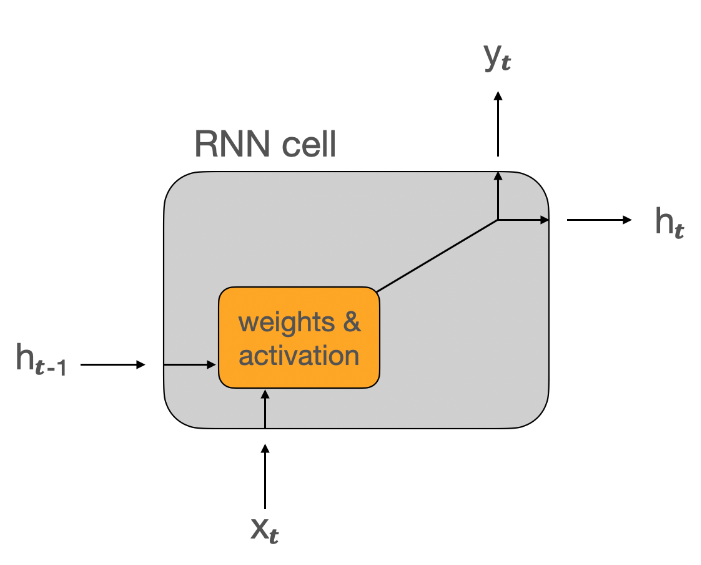

An regular RNN cell inputs the current input data x and the previous hidden state h and outputs the current output and the next hidden state.

## LSTM (Long short term memory)

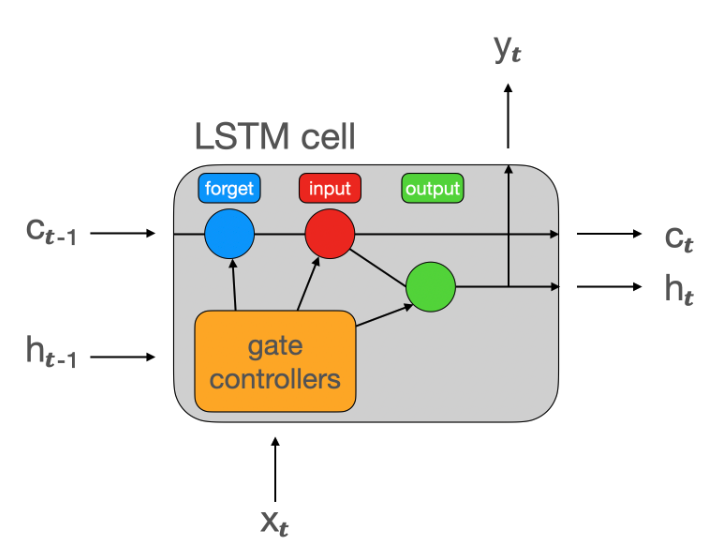

- h is the short term memory
- c is the long term state
There are three gates
- Forget gate: what to remove from long term memory
- Input gate: what to save to long term memory
- Output gate: what to return

In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.rnn = nn.LSTM(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x): 
        # Lets initialize hidden states c and h to 0s
        h0 = torch.zeros(2, x.size(0), 32) 
        c0 = torch.zeros(2, x.size(0), 32) 
        out, _ = self.rnn(x, (h0, c0))
        # select the last output and pass it through the linear layer
        out = self.fc(out[:, -1, :])
        return out

## GRU (Gated Recurrent Unit)

Could be considered a simplified version of the LSTM cell
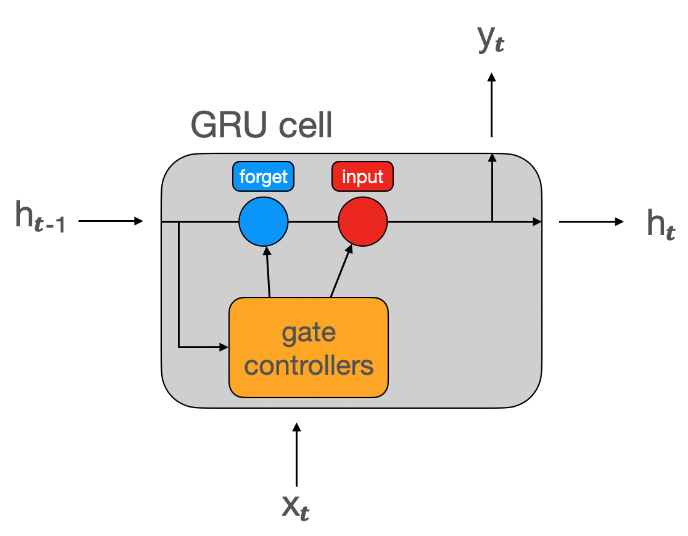

It has just one hidden state
No output gate 


In [ ]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.rnn = nn.GRU(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True,
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x): 
        # Lets initialize hidden state h to 0s
        h0 = torch.zeros(2, x.size(0), 32) 
        out, _ = self.rnn(x, h0)
        # select the last output and pass it through the linear layer
        out = self.fc(out[:, -1, :])
        return out

Which one to pick? 
- RNNs are not used anymore these days due to their short memory issue
- GRU has the advantage of being simpler than LSTM, which implies less computation
- Its a good idea to try both LSTM and GRU and compare their results


# Expanding Tensors 

Recurrent layers expect input shape (batch_size, seq_length, num_features). When we retrieve the data from the dataloader we receive (batch_size, seq_length). We must add an extra dimension at the end. We can do seo zith the *.view()* method

# Squeezing Tensors 

The other way around, when we want to reduce one dimension we can use the *.squeeze()* method. 

# Training Loop


In [ ]:
dataloader_train = DataLoader(
    dataset_train, 
    shuffle = False,
    batch_size=32
)

net = Net()
criterion = nn.MSELoss()  
optimizer = optim.Adam(
    net.parameters(), lr=0.001
)
num_epochs = 1

for epoch in range(num_epochs): 
    for seqs, labels in dataloader_train: 
        seqs = seqs.view(32, 96, 1) 
        outputs = net(seqs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


# Evaluation loop 

In [ ]:
import torchmetrics 

mse = torchmetrics.MeanSquaredError()

net.eval() 
with torch.no_grad(): 
    for seqs, labels in dataloader_test: 
        seqs = seqs.view(32, 96, 1)
        outputs = net(seqs).squeeze()

# MultiInput Models 

Multi input models accept more than one source of data: two images to perform comparison, images and text...

Lets build a model that inputs an image of a character of the omniglot dataset and a one hot encoded vector with the alphabet. The output will be the character itself



In [ ]:
from PIL import Image

class OmniglotDataset(Dataset): 
    def __init__(self, transform, samples): 
        self.transform = transform 
        self.samples = samples 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx): 
        img_path, alphabet, label = self.samples[idx]
        img = Image.open(img_path).convert('L')
        img = self.transform(img) 
        return img, alphabet, label

dataset_train = OmniglotDataset(
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ]),
    samples=samples,
)

dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=3,
)

class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), 
            nn.MaxPool2d(kernel_size=2), 
            nn.ELU(), 
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        self.alphabet_layer = nn.Sequential(
            nn.Linear(30, 8),
            nn.ELU(), 
        )
        self.classifier = nn.Sequential(
            nn.Linear(128+8, 964),
        )
        
    def forward(self, x_image, x_alphabet): 
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifier(x)

net = Net() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.01)

for epoch in range(10): 
    for img, alpha, labels in dataloader_train: 
        optimizer.zero_grad() 
        outputs = net(img, alpha) 
        loss = criterion(outputs, labels) 
        loss.backward() 
        optimizer.step()

# Multi Output PENDING